# Zero-Shot Classification using CLAP Models

In [5]:
from msclap import CLAP
import laion_clap
import json
import pandas as pd
from dataset import DatasetUCS
import torch
import matplotlib.pyplot as plt
import configs.graphics_settings as graphics_settings
import random
import IPython.display as ipd
from sklearn.manifold import TSNE

In [6]:
# Load Testing Set
with open ('configs/msclap.json', 'r') as f:
    settings = json.load (f)

# Load USC Classes
with open ('contrastive_reranking/ucs_classes.json', 'r') as f:
    ucs_classes = json.load (f)

test_df = pd.read_csv(settings['dataset_drive'] + settings['test_set_path'])
test_set = DatasetUCS(test_df, settings, device='cpu', return_type='path')

msclap_model = CLAP(version = '2023', use_cuda=False) # version can be 2022 or 2023
#laion_clap_model = laion_clap.CLAP_Module(enable_fusion=False)
#laion_clap_model.load_ckpt()


## MS CLAP
This section evaluates MSCLAP on Soundly-80k through the following metrics: Precision, Recall, Mean Average Precision

In [26]:
sample_idx = random.randint(0, len(test_set))
path, label, class_name = test_set[sample_idx]

# Extract Embeddings
audio_embeddings = msclap_model.get_audio_embeddings([path])
label_embeddings = msclap_model.get_text_embeddings(test_set.get_unique_classes())
similarities = msclap_model.compute_similarity(audio_embeddings, label_embeddings)

similarities = similarities.detach()
print(f"Shape: {similarities.shape}")
probs = torch.softmax(similarities, dim=1).detach().flatten() * 100
idx = torch.argmax(probs)
print(f"Predicted Class (Best Prediction): {test_set.get_unique_classes()[idx]}")
indeces = torch.topk(probs, k=3).indices
print(f"Predicted Classes (Best Match To Worst): {test_set.get_unique_classes()[indeces[0]]}, {test_set.get_unique_classes()[indeces[1]]}, {test_set.get_unique_classes()[indeces[2]]}")
print(f"True Class: {class_name}")

#ipd.Audio(filename=path)

Shape: torch.Size([1, 81])
Predicted Class (Best Prediction): swooshes
Predicted Classes (Best Match To Worst): swooshes, movement, bullets
True Class: swooshes


<BarContainer object of 81 artists>

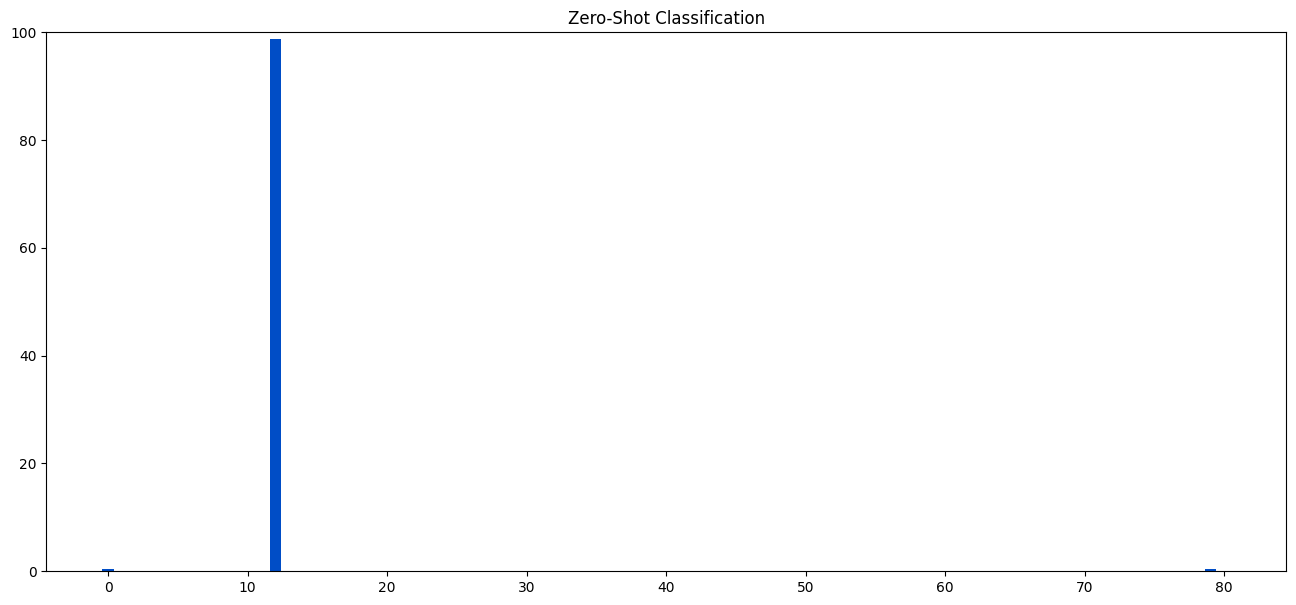

In [4]:
fig = plt.figure(2, figsize=(16, 7))
ax = fig.subplots(1)
ax.set_title("Zero-Shot Classification")
ax.set_ylim(0, 100)
ax.bar(range(len(probs)), height=probs, color=graphics_settings.primary_color)

# Testing Framework

In [30]:
from sklearn.metrics import accuracy_score, average_precision_score
from tqdm import tqdm

k_tests = 1000

label_embeddings = msclap_model.get_text_embeddings(list(ucs_classes['class_to_int'].keys()))

pred = []
true = []
for i in tqdm(range(k_tests)):
    sample_idx = random.randint(0, len(test_set)-1)
    path, label, class_name = test_set[sample_idx]

    audio_embeddings = msclap_model.get_audio_embeddings([path])
    similarities = msclap_model.compute_similarity(audio_embeddings, label_embeddings)
    similarities = similarities.detach()

    probs = torch.softmax(similarities, dim=1).detach().flatten() * 100
    idx = torch.argmax(probs)
    pred.append(idx.item())
    true.append(ucs_classes['class_to_int'][class_name])

    #indeces = torch.topk(probs, k=3).indices


#similarities = similarities.detach()
#print(f"Shape: {similarities.shape}")

#print(f"Predicted Class (Best Prediction): {test_set.get_unique_classes()[idx]}")
#indeces = torch.topk(probs, k=3).indices
#print(f"Predicted Classes (Best Match To Worst): {test_set.get_unique_classes()[indeces[0]]}, {test_set.get_unique_classes()[indeces[1]]}, {test_set.get_unique_classes()[indeces[2]]}")
#print(f"True Class: {class_name}")

100%|██████████| 1000/1000 [22:56<00:00,  1.38s/it] 


In [38]:
import numpy as np
accuracy = accuracy_score(true, pred)
print(f"Accuracy Score: {accuracy}")
ap = average_precision_score(np.array(true).reshape(-1, 1), np.array(pred).reshape(-1, 1))
print(f"Average Precision Score: {ap}")

Accuracy Score: 0.279
Average Precision Score: 0.006289124641864409


In [32]:
# IDEA: framework lets you easily add and remove classes.

print(pred)
print(true)

[52, 47, 69, 70, 70, 72, 1, 57, 32, 70, 23, 7, 78, 68, 70, 12, 25, 28, 66, 68, 70, 70, 72, 70, 34, 72, 70, 72, 20, 66, 66, 12, 70, 1, 66, 3, 68, 34, 22, 70, 52, 72, 70, 70, 46, 70, 20, 24, 28, 32, 4, 18, 11, 9, 53, 70, 70, 13, 58, 72, 70, 22, 46, 7, 70, 28, 18, 34, 20, 66, 52, 14, 23, 23, 3, 22, 7, 46, 3, 18, 70, 60, 1, 32, 31, 5, 28, 8, 3, 70, 13, 35, 7, 58, 3, 8, 72, 18, 32, 5, 68, 70, 18, 72, 18, 70, 70, 68, 24, 70, 23, 46, 68, 50, 72, 22, 46, 70, 70, 8, 59, 13, 70, 16, 27, 70, 70, 53, 34, 32, 72, 70, 52, 5, 37, 70, 46, 34, 3, 19, 70, 3, 46, 70, 66, 68, 18, 46, 18, 52, 3, 3, 22, 20, 78, 11, 72, 72, 28, 41, 53, 26, 52, 11, 60, 57, 32, 72, 5, 59, 70, 24, 70, 72, 74, 66, 11, 5, 45, 72, 78, 18, 54, 70, 66, 72, 57, 67, 18, 58, 16, 66, 50, 72, 32, 70, 60, 19, 52, 18, 72, 70, 70, 13, 8, 45, 28, 67, 68, 70, 5, 22, 52, 63, 19, 70, 7, 12, 4, 72, 52, 70, 34, 46, 9, 23, 72, 18, 72, 34, 70, 46, 70, 1, 70, 4, 20, 28, 60, 46, 24, 70, 70, 23, 45, 3, 20, 58, 73, 70, 72, 16, 78, 46, 25, 41, 18, 45, 7

In [ ]:
def perform_evaluation(clap_model, metrics, test_set):
    """

    Args:
    - clap_model: pre-trained msclap or laion_clap mdoel
    - metrics: literal string list. 
    """


perform_evaluation(msclap_model)

